In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = False
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['font.sans-serif'] = 'IBM Plex Sans Condensed'

In [3]:
files = glob("../data/ChokepointPotential/201*/*.txt")

In [4]:
month_map = {"Jan":1,
             "Feb":2,
             "Mar":3,
             "Apr":4,
             "May":5,
             "Jun":6,
             "Jul":7,
             "Aug":8,
             "Sep":9,
             "Oct":10,
             "Nov":11,
             "Dec":12}

In [5]:
def year_month(fname):
    l = fname.split("/")
    year = int(l[-2][0:4])
    month = l[-2][4:7]
    return year, month_map[month]

In [6]:
def get_type(fname):
    l = fname.split("/")
    return l[-1].split(".")[-2].split("_")[-1]

In [7]:
def get_df_choke(fname):
    df = pd.read_csv(fname,sep="|",header=None,names=["ASN","CC","Chokepoint"])
    year,month = year_month(fname)
    df['year'] = year
    df['month'] = month
    df['date'] = year + (month-1)/12.0
    df['direction'] = get_type(fname)
    #df['log_chokepoint'] = np.log10(df['Chokepoint'])
    return df[(df.CC != "  ")]

In [8]:
df_choke = pd.concat(map(get_df_choke,files))

In [59]:
df_cc = pd.read_csv("../data/cc_to_continent2.csv").drop_duplicates(['CC','Country'])

In [10]:
d = df_cc[['CC','Country']].set_index('CC').to_dict(orient='index')
CC_map = {CC:d['Country'] for CC,d in d.items()}

In [11]:
fotn_files = glob("../data/FOTN/*.csv")

In [12]:
def get_df_fotn(fname):
    df = pd.read_csv(fname,sep="|",header=None,
                     names=['Country','Status','FOTN_Total','FOTN_OtA','FOTN_LoC','FOTN_VoUR'],
                     converters={"Country":str.strip}).merge(df_cc[['Country','CC']],on='Country',how='left')
    df['year'] = int(fname.split("/")[-1].split(".")[0][-4:])
    return df

In [13]:
df_fotn = pd.concat(map(get_df_fotn,fotn_files))

In [14]:
def numASNs(data,threshes=[0.1,0.5,0.9]):
    #print(data.CC.unique(),data.date.unique())
    rows = []
    data = data.sort_values('Chokepoint',ascending=False)
    data['Cum_Chokepoint'] = data.Chokepoint.cumsum()
    year = data.year.unique()[0]
    for thresh in threshes:
        r = {'threshhold':thresh,'year':year}
        idxs = np.where(data.Cum_Chokepoint < thresh)[0]
        if idxs.shape[0]==0:
            r['numASNs'] = 1
        else:
            r['numASNs'] = idxs.max() + 1
        rows.append(r)
    return pd.DataFrame(rows)

In [15]:
def totalControl(data, num_ASNs=[1,2,3,5,10,20,50]):
    data = data.sort_values("Chokepoint",ascending=False)
    data['Cum_Chokepoint'] = data.Chokepoint.cumsum()
    year = data.year.unique()[0]
    rows = []
    for n in num_ASNs:
        if n > data.shape[0]:
            rows.append({'num_ASNs':n,"CumulativeChokepoint": 1.0,'year':year})
        else:
            rows.append({'num_ASNs':n,"CumulativeChokepoint": data.iloc[n-1].Cum_Chokepoint,'year':year})
    return pd.DataFrame(rows)

In [16]:
dfg = df_choke[['CC','date','Chokepoint','direction','year']].groupby(['CC','date','direction'])

In [17]:
df_numASNs = dfg.apply(numASNs,threshes=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).reset_index()
df_cumchoke = dfg.apply(totalControl).reset_index()
del df_numASNs['level_3']
del df_cumchoke['level_3']

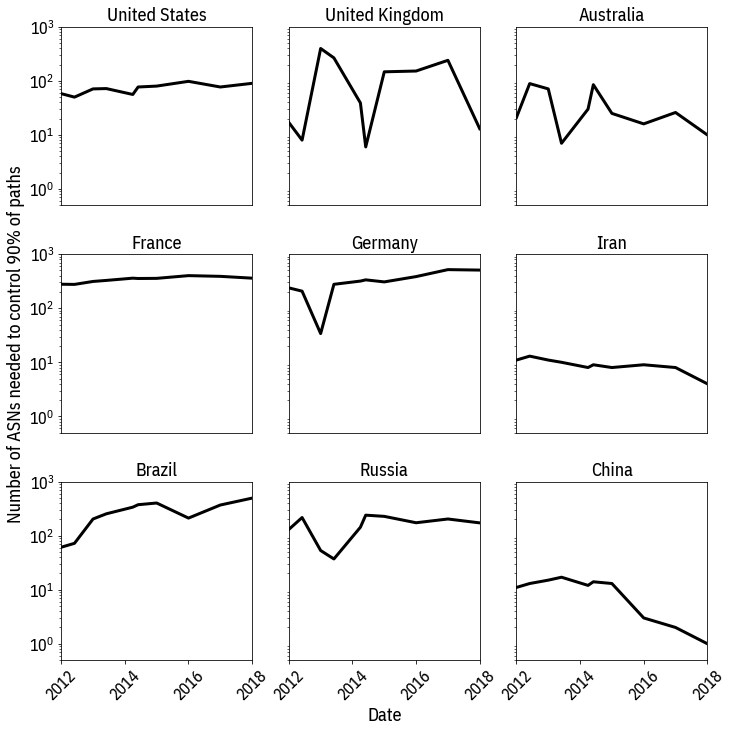

In [18]:
plt.figure(figsize=(10,10))
i = 1
thresh = 0.9
direction = 'ito'
for CC in ['US','GB','AU','FR','DE','IR','BR','RU','CN']:
    plt.subplot(3,3,i)
    filt = (df_numASNs.CC==CC) & (df_numASNs.threshhold==thresh) & (df_numASNs.direction==direction)
    data = df_numASNs[filt].sort_values('date')
    #plt.fill_between(ds,data[0.25],data[0.9],color='k',alpha=0.2)
    plt.plot(data.date,data.numASNs,color='k',lw=3)
    plt.yscale('log')
    plt.xlim(df_choke.date.min(),df_choke.date.max())
    plt.ylim(0.5,1e3)
    plt.title(CC_map[CC])
    if i < 7:
        plt.xticks([])
    else:
        plt.xticks(rotation=45)
    if (i-1) % 3 != 0:
        plt.yticks([])
    if i==4:
        plt.ylabel("Number of ASNs needed to control %2.0f%% of paths"%(100*thresh))
    if i==8:
        plt.xlabel("Date")
    i+=1
plt.tight_layout(pad=0.1,h_pad=-7)

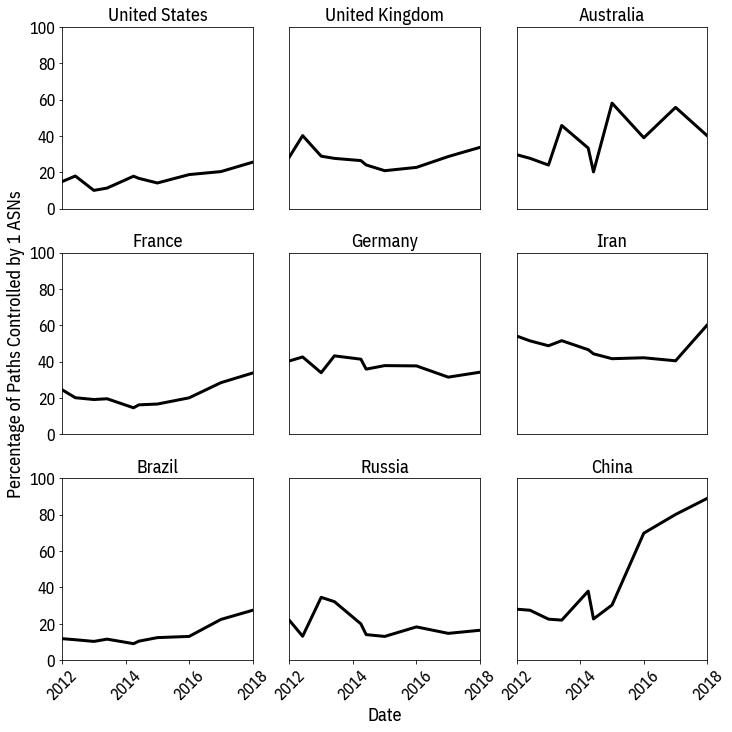

In [19]:
plt.figure(figsize=(10,10))
i = 1
num_ASNs = 1
direction = 'ito'
for CC in ['US','GB','AU','FR','DE','IR','BR','RU','CN']:
    plt.subplot(3,3,i)
    filt = (df_cumchoke.CC==CC) & (df_cumchoke.num_ASNs==num_ASNs) & (df_cumchoke.direction==direction)
    data = df_cumchoke[filt].sort_values('date')
    #plt.fill_between(ds,data[0.25],data[0.9],color='k',alpha=0.2)
    plt.plot(data.date,100*data.CumulativeChokepoint,color='k',lw=3)
    plt.xlim(df_choke.date.min(),df_choke.date.max())
    plt.ylim(0,100)
    plt.title(CC_map[CC])
    if i < 7:
        plt.xticks([])
    else:
        plt.xticks(rotation=45)
    if (i-1) % 3 != 0:
        plt.yticks([])
    if i==4:
        plt.ylabel("Percentage of Paths Controlled by %d ASNs"%(num_ASNs))
    if i==8:
        plt.xlabel("Date")
    i+=1
plt.tight_layout(pad=0.1,h_pad=-5)

In [46]:
df_m = df_numASNs.merge(df_fotn,on=['year','CC'],how='right')

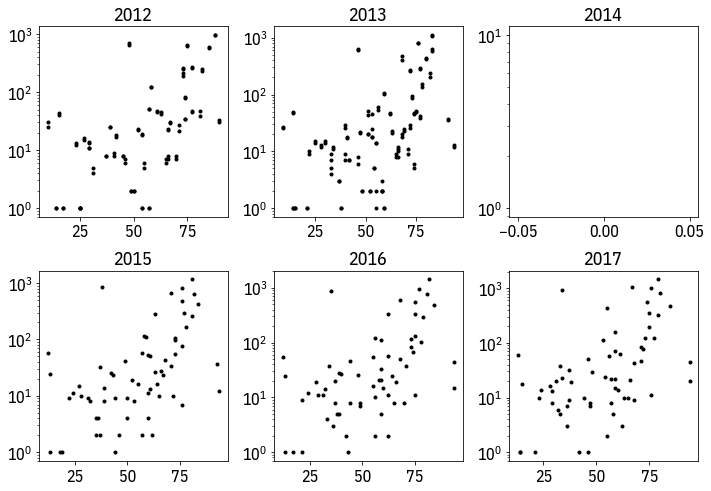

In [58]:
plt.figure(figsize=(10,10))
i = 1
for y in range(2012,2018):
    data = df_m[(df_m.direction=='ito') & (df_m.year==y) & (df_m.threshhold==0.99)]
    plt.subplot(3,3,i)
    plt.plot(100-data.FOTN_Total,data.numASNs,'k.')
    plt.yscale('log')
    plt.title(y)
    i+=1
plt.tight_layout()